In [26]:
import pandas as pd 
import numpy as np
from utils import *
import time
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
%matplotlib inline
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config))

In [2]:
df = pd.read_csv("./data/CONTEST_DATA_IN_SAMPLE_1.csv",header=None)
df2 = pd.read_csv("./data/CONTEST_DATA_IN_SAMPLE_2.csv",header=None)
df = pd.concat([df,df2])
df.columns = ['time','stkcd','open','high','low','close','volume']

In [3]:
close_df = pd.DataFrame()
high_df = pd.DataFrame()
low_df = pd.DataFrame()
volume_df = pd.DataFrame()
for sub_df in df.groupby('stkcd'):
    close_df[sub_df[0]] = sub_df[1].reset_index().close
    high_df[sub_df[0]] = sub_df[1].reset_index().high
    low_df[sub_df[0]] = sub_df[1].reset_index().low
    volume_df[sub_df[0]] = sub_df[1].reset_index().volume
highs = high_df.values
lows = low_df.values
closes = close_df.values
volumes = volume_df.values

In [17]:
horizon = 1
rts = close_df.pct_change(horizon).shift(-horizon-1).fillna(0).values # returns

In [11]:
a = np.empty((0,351))

In [37]:
start = time.time()
# a = np.vstack([a,mfi])
mfis.append(mfi)
end = time.time()
print((end-start)*10000000)
# a.shape

0.0


In [36]:
len(mfis)

913

In [38]:
closes.shape

(1900, 351)

In [5]:
avgs = np.empty((0,closes.shape[1]))
moms = np.empty((0,closes.shape[1]))
vols = np.empty((0,closes.shape[1]))
max52s = np.empty((0,closes.shape[1]))
min52s = np.empty((0,closes.shape[1]))
ccis = np.empty((0,closes.shape[1]))
Ks = np.empty((0,closes.shape[1]))
Ds = np.empty((0,closes.shape[1]))
Js = np.empty((0,closes.shape[1]))
rsis = np.empty((0,closes.shape[1]))
trixs = np.empty((0,closes.shape[1]))
willrs = np.empty((0,closes.shape[1]))
macds = np.empty((0,closes.shape[1]))
natrs = np.empty((0,closes.shape[1]))
mfis = np.empty((0,closes.shape[1]))
start = time.time()
for i in range(1,len(closes)+1):
    c = closes[:i]
    h = highs[:i]
    l = lows[:i]
    v = volumes[:i]
    avg=get_avg(c,3)
    mom=get_mom(c,5)
    vol=get_vol(c,5)
    max52=get_52weekhigh(c)
    min52=get_52weeklow(c)
    cci = get_cci(h,l,c)
    K,D,J = get_kdj(h,l,c)
    rsi = get_rsi(c)
    trix = get_trix(c)
    willr = get_willr(h,l,c)
    macd = get_macd(c)
    natr = get_natr(h,l,c)
    mfi = get_mfi(c,h,l,v)

    avgs=np.vstack([avgs,avg])
    moms=np.vstack([moms,mom])
    vols=np.vstack([vols,vol])
    max52s=np.vstack([max52s,max52])
    min52s=np.vstack([min52s,min52])
    ccis=np.vstack([ccis,cci])
    Ks=np.vstack([Ks,K])
    Ds=np.vstack([Ds,D])
    Js=np.vstack([Js,J])
    rsis=np.vstack([rsis,rsi])
    trixs=np.vstack([trixs,trix])
    willrs=np.vstack([willrs,willr])
    macds=np.vstack([macds,macd])
    natrs=np.vstack([natrs,natr])
    mfis=np.vstack([mfis,mfi])
    if i%100 == 0:
        print(i)
endtime = time.time()
# print((start-endtime)*1000 / 1900)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [6]:
print((endtime-start) / 1900)

0.08795271082928306


In [11]:
print((endtimpppe-start) / 1900)

0.07307400414818212


In [7]:
a = mfis[100]

In [44]:
def get_performance(factors,returns,top_n=10,tail_n=10,reverse=False,show=False):
    profits = []
    for i,x in enumerate(zip(factors,returns)):
        daily_factor,daily_return = x[0],x[1]
        daily_factor = pd.Series(daily_factor)
        head = daily_factor.nlargest(top_n).index.tolist()
        tail = daily_factor.nsmallest(tail_n).index.tolist()
        profit = daily_return[head].mean() - daily_return[tail].mean()
        if reverse:
            profit = -profit
        profits.append(profit)
    sharpe = np.sqrt(250) * np.nanmean(profits) / np.nanstd(profits)
    cum_profit = pd.Series(np.asarray(profits)+1).cumprod()
    totalprofit = cum_profit.iloc[-1] - 1
    annual = totalprofit * 252 / returns.shape[0]
    maxdd = (cum_profit-cum_profit.expanding().max()).min()
    if show:
        plt.show()
    return profits,{
        'Total Return':totalprofit,
        'Annual Return':annual,
        'Sharpe Ratio':sharpe,
        'MaxDD':maxdd}

In [45]:
prof, all_results['mom'] = get_performance(moms,rts,reverse=True)

In [53]:
cum_profit = (pd.Series(prof)).cumsum()
maxdd = (cum_profit-cum_profit.expanding().max()).min()

In [54]:
maxdd

-0.24788177843408477

In [43]:
pd.DataFrame(all_results).T

,Total Return,Annual Return,Sharpe Ratio,MaxDD
avg,50.904201,6.751505,2.057582,-3.382555
mom,217.680733,28.871339,2.205558,-53.737019
vol,11.307171,1.499688,1.177843,-3.307538
max52,1.397475,0.185349,0.663979,-0.533917
min52,1.397475,0.185349,0.663979,-0.533917
cci,1.397475,0.185349,0.663979,-0.533917
K,23.080138,3.061155,2.091158,-2.024070
D,23.398887,3.103431,2.108682,-2.458000
J,9.348372,1.239889,1.595170,-1.281415
trix,2.608193,0.345929,0.681773,-4.187431


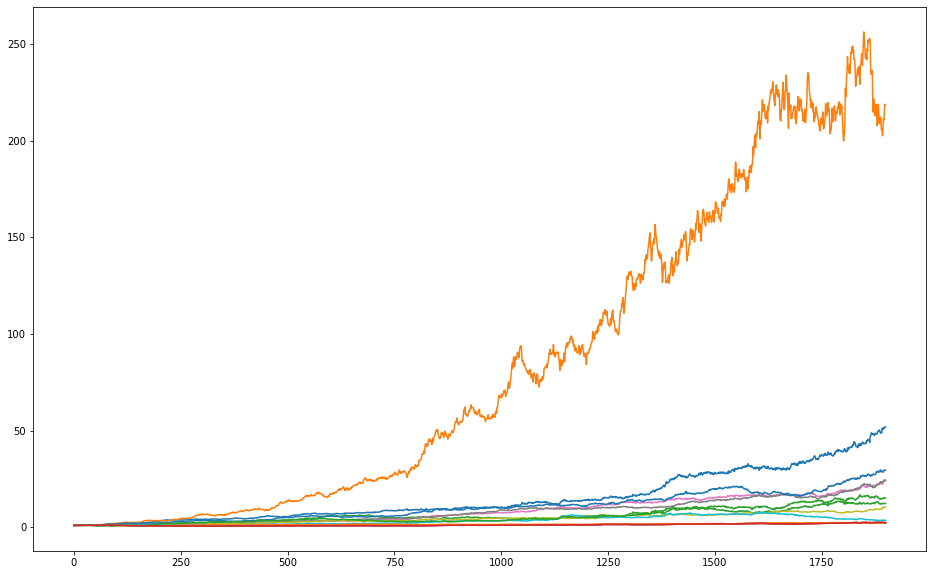

In [42]:
plt.figure(figsize=(16,10))
all_results = {}
prof, all_results['avg'] = get_performance(avgs,rts,reverse=True)
plt.plot(prof,label='avg')
prof, all_results['mom'] = get_performance(moms,rts,reverse=True)
plt.plot(prof,label='mom')
prof, all_results['vol'] = get_performance(vols,rts,reverse=False)
plt.plot(prof,label='vol')
prof, all_results['max52'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='max52')
prof, all_results['min52'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='min52')
prof, all_results['cci'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='cci')
prof, all_results['K'] = get_performance(Ks,rts,reverse=True)
plt.plot(prof,label='K')
prof, all_results['D'] = get_performance(Ds,rts,reverse=True)
plt.plot(prof,label='D')
prof, all_results['J'] = get_performance(Js,rts,reverse=False)
plt.plot(prof,label='J')
prof, all_results['trix'] = get_performance(trixs,rts,reverse=True)
plt.plot(prof,label='trix')
prof, all_results['willr'] = get_performance(willrs,rts,reverse=False)
plt.plot(prof,label='willr')
prof, all_results['macd'] = get_performance(macds,rts,reverse=True)
plt.plot(prof,label='macd')
prof, all_results['natr'] = get_performance(natrs,rts,reverse=False)
plt.plot(prof,label='natr')
prof, all_results['mfi'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='mfi')

In [ ]:
# given factors and returns, output test results.
profits = []
for i,x in enumerate(zip(factors,returns)):
    daily_factor,daily_return = x[0],x[1]
    daily_factor = pd.Series(daily_factor)
    head = daily_factor.nlargest(10).index.tolist()
    tail = daily_factor.nsmallest(10).index.tolist()
    profit = daily_return[head].mean() - daily_return[tail].mean()
    profits.append(profit)
pd.Series(np.asarray(profits)+1).cumprod().plot()
plt.show()


out_profits = []
for i,x in enumerate(zip(factors,returns)):
    daily_factor,daily_return = x[0],x[1]
    head = daily_factor.nlargest(10).index.tolist()
    tail = daily_factor.nsmallest(10).index.tolist()
    profit = daily_return[head].mean() - daily_return[tail].mean()
    out_profits.append(profit)
pd.Series(np.asarray(profits)+1).cumprod().plot()
plt.show()